# Pipeline DSC:
In questo programma il fine è confrontare due tipi differenti di analisi: quella sulla base dei dati forniti da CD e quella classica a due componenti di Van't Hoff.
Si procederà dunque con la stesura di tutti e 3 i fit:
- 3 Gaussiane per simulare 3 stati intermedi;
- 1 funzione di Van't Hoff;
- 1 singola Gaussiana.

Al fine poi di confrontare la bontà dei fit.

# Carico il df di Tel23 completo:

In [ ]:
# --- Header per path & ordinamenti deterministici ---
import os, re
from pathlib import Path

BASE = Path.cwd() / "Dati"

def natural_key(s: str):
    """Ordina t1,t2,...,t10 come 1<2<...<10 (anziché t1,t10,t2...)."""
    return [int(t) if t.isdigit() else t.lower() for t in re.split(r'(\d+)', s)]
# -----------------------------------------------------


['Temperatura', 'Cp_corretto', 'Cp_baseline', 'Cp_finale_cubica']


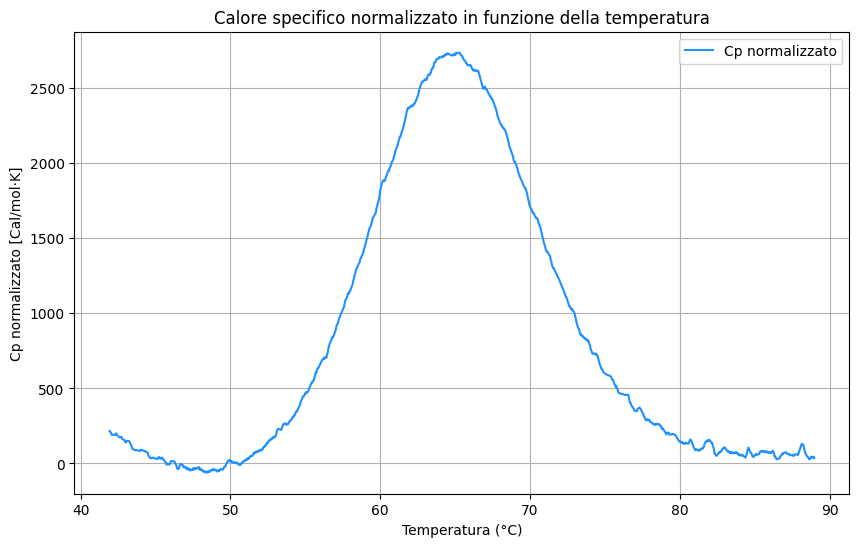

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.stats import linregress
from scipy.interpolate import interp1d



# === Carica il file CSV ===

folder_path1 = BASE / "ci_puliti"   # se i file che usi sono in quella cartella


for filename in sorted(os.listdir(folder_path1), key=natural_key):
    if filename == "c3_cubica.csv":
        path = os.path.join(folder_path, filename)
        df_corr = pd.read_csv(path, sep="\t", )

print(df_corr.columns.tolist())

plt.figure(figsize=(10, 6))
# === Grafico Cp normalizzato in funzione della temperatura ===
plt.plot(df_corr["Temperatura"], df_corr["Cp_finale_cubica"], label="Cp normalizzato", color='dodgerblue')
plt.xlabel("Temperatura (°C)")
plt.ylabel("Cp normalizzato [Cal/mol·K]")
plt.title("Calore specifico normalizzato in funzione della temperatura")
plt.grid(True)
plt.legend()
plt.show()


# Fit Campione c3 con baseline cubica a più componenti, secondo i risultati di SVD:

Nel processo di valutazione degli stati intermedi attraverso l'analisi SVD dei dati di dicroismo circolare precedentemente analizzati.
Le Temperature di melting del campione Tel23 sono le seguenti:
- 56.3 °C;
- 61.3 °C;
- 79.5 °C.

In base a queste Temperature di melting si è deciso di fittare 3 funzioni Gaussiane: 
$$
C_p(T) = 
A_1 \cdot \exp\left(-\frac{(T - T_{m1})^2}{2\sigma_1^2}\right) +
A_2 \cdot \exp\left(-\frac{(T - T_{m2})^2}{2\sigma_2^2}\right) +
A_3 \cdot \exp\left(-\frac{(T - T_{m3})^2}{2\sigma_3^2}\right)
$$

Dove:
- $C_p(T)$: calore specifico a temperatura $T$.
- $A_i$: ampiezza (altezza) della $i$-esima gaussiana;
- $\sigma_i$: larghezza (deviazione standard) della $i$-esima gaussiana;
- $T_{mi}$: centro della $i$-esima gaussiana, corrispondente alla temperatura di melting ($T_m$).

Lasciando le temperature di melting fisse per far sì che il fit spieghi gli stati intermedi forniti.

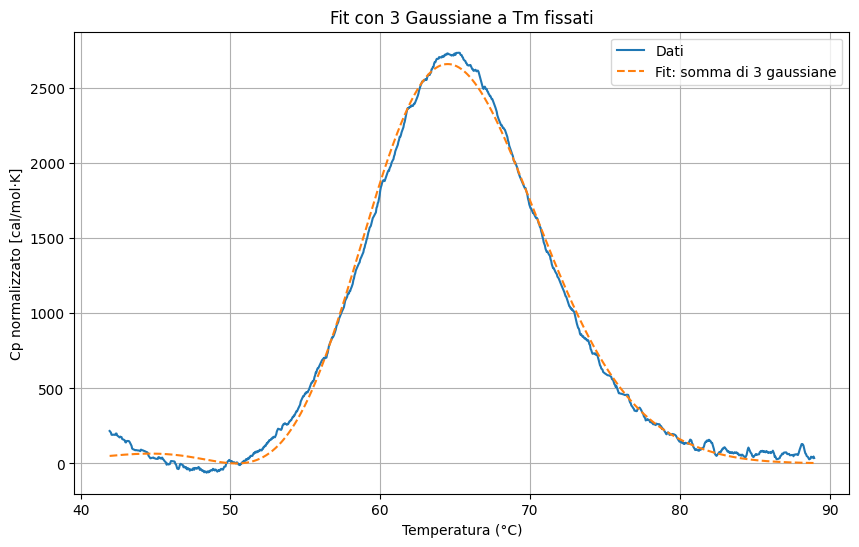

MAE (fixed Tm): 47.5987 cal/mol·K
MSE (fixed Tm): 3203.4003 (cal/mol·K)^2
Chi² ridotto (fixed Tm): 3220.5613


In [2]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

Tm1_C = 329.46843033838434 - 273.15  # ≈ 56.3 °C
Tm2_C = 334.4127568316971  - 273.15  # ≈ 61.3 °C
Tm3_C = 352.6269312480101  - 273.15  # ≈ 79.5 °C

# === Definizione funzione ===
def triple_gaussian_fixed_centers(T, A1, sigma1, A2, sigma2, A3, sigma3):
    return (
        A1 * np.exp(-((T - Tm1_C) ** 2) / (2 * sigma1 ** 2)) +
        A2 * np.exp(-((T - Tm2_C) ** 2) / (2 * sigma2 ** 2)) +
        A3 * np.exp(-((T - Tm3_C) ** 2) / (2 * sigma3 ** 2))
    )


# Fit
popt, pcov = curve_fit(triple_gaussian_fixed_centers, df_corr["Temperatura"], df_corr["Cp_finale_cubica"], p0=[2000, 2, 2000, 2, 2000, 2])

# Parametri ottimizzati
# Salvo i risultati del primo fit con Tm fissi
A1_f, sigma1_f, A2_f, sigma2_f, A3_f, sigma3_f = popt


# Plot
plt.figure(figsize=(10, 6))
plt.plot(df_corr["Temperatura"], df_corr["Cp_finale_cubica"], label='Dati')
plt.plot(df_corr["Temperatura"], triple_gaussian_fixed_centers(df_corr["Temperatura"], *popt), '--', label='Fit: somma di 3 gaussiane')
plt.xlabel('Temperatura (°C)')
plt.ylabel('Cp normalizzato [cal/mol·K]')
plt.legend()
plt.title('Fit con 3 Gaussiane a Tm fissati')
plt.grid()
plt.show()


# === Dati ===
T = df_corr["Temperatura"].values
Cp = df_corr["Cp_finale_cubica"].values
Cp_fit_fixed = triple_gaussian_fixed_centers(T, *popt)

residui_fixed = Cp - Cp_fit_fixed
dof_fixed = len(Cp) - len(popt)
mae_fixed = mean_absolute_error(Cp, Cp_fit_fixed)
mse_fixed = mean_squared_error(Cp, Cp_fit_fixed)
chi2_red_fixed = np.sum(residui_fixed**2) / dof_fixed

# === Stampa risultati ===
print(f"MAE (fixed Tm): {mae_fixed:.4f} cal/mol·K")
print(f"MSE (fixed Tm): {mse_fixed:.4f} (cal/mol·K)^2")
print(f"Chi² ridotto (fixed Tm): {chi2_red_fixed:.4f}")


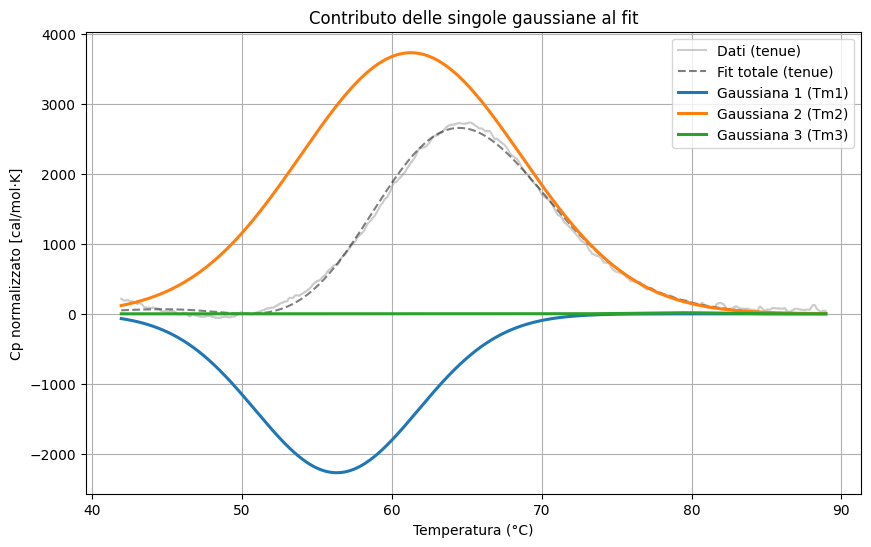

In [3]:
# === Singole gaussiane ===
T = df_corr["Temperatura"].values
Cp = df_corr["Cp_finale_cubica"].values

gauss1__fixed = A1_f * np.exp(-((T - Tm1_C) ** 2) / (2 * sigma1_f ** 2))
gauss2_fixed = A2_f * np.exp(-((T - Tm2_C) ** 2) / (2 * sigma2_f ** 2))
gauss3_fixed = A3_f * np.exp(-((T - Tm3_C) ** 2) / (2 * sigma3_f ** 2))
fit_totale = gauss1__fixed + gauss2_fixed + gauss3_fixed

# === Plot evidenziando le 3 gaussiane ===
plt.figure(figsize=(10,6))
plt.plot(T, Cp, color='gray', alpha=0.4, label='Dati (tenue)')
plt.plot(T, fit_totale, color='black', linestyle='--', alpha=0.5, label='Fit totale (tenue)')

plt.plot(T, gauss1__fixed, label='Gaussiana 1 (Tm1)', linewidth=2.2)
plt.plot(T, gauss2_fixed, label='Gaussiana 2 (Tm2)', linewidth=2.2)
plt.plot(T, gauss3_fixed, label='Gaussiana 3 (Tm3)', linewidth=2.2)

plt.xlabel('Temperatura (°C)')
plt.ylabel('Cp normalizzato [cal/mol·K]')
plt.title('Contributo delle singole gaussiane al fit')
plt.legend()
plt.grid()
plt.show()


Notando i risultati incoraggianti di questo fit si è deciso di refittare il tutto lasciando le $Tm_i$ libere di variare entro gli errori sperimentali dati dal metodo *Monte Carlo* con il quale si sono valutati gli stessi nel programma di fit e ricostruzione spettrale di SVD.

Tm ed errori sono: 
- ($56.3 \pm 2.6$) °C;
- ($61.3 \pm 0.4$) °C;
- ($79.5 \pm 1.4$) °C.

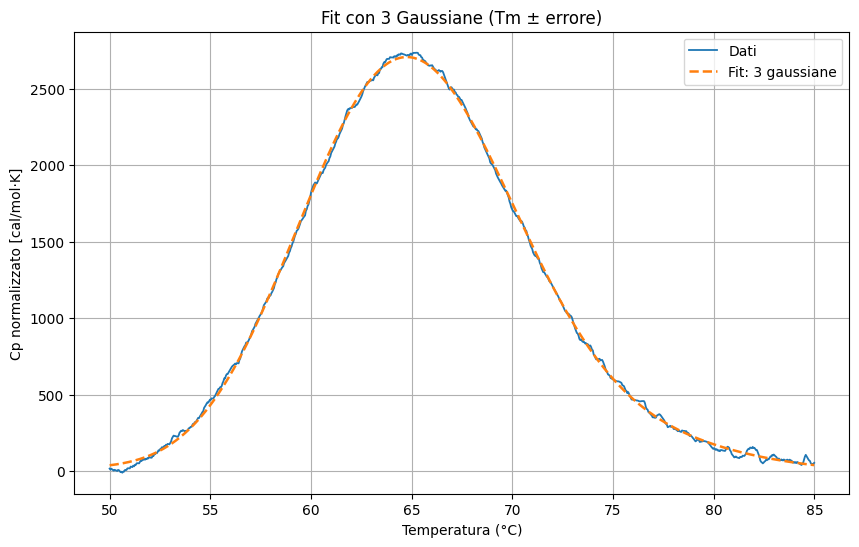

Tm1 = 58.88 °C (± 2.56)
Tm2 = 61.64 °C (± 0.37)
Tm3 = 78.14 °C (± 1.39)

MAE: 18.11 cal/mol·K
MSE: 484.11 (cal/mol·K)^2
Chi² ridotto: 489.3663


In [4]:


# === Conversione Tm e incertezze da K a °C ===
Tm1_C, err1 = 329.46843033838434 - 273.15, 2.5584027780087473
Tm2_C, err2 = 334.4127568316971  - 273.15, 0.37382475660932163
Tm3_C, err3 = 352.6269312480101  - 273.15, 1.385632121088951

# === Funzione: somma di 3 gaussiane con Tm variabili ===
def triple_gaussian(T, A1, sigma1, Tm1, A2, sigma2, Tm2, A3, sigma3, Tm3):
    return (
        A1 * np.exp(-((T - Tm1)**2) / (2 * sigma1**2)) +
        A2 * np.exp(-((T - Tm2)**2) / (2 * sigma2**2)) +
        A3 * np.exp(-((T - Tm3)**2) / (2 * sigma3**2))
    )

# === Dati ===
mask = (df_corr["Temperatura"] >= 50) & (df_corr["Temperatura"] <= 85)
T = df_corr["Temperatura"][mask].values
Cp = df_corr["Cp_finale_cubica"][mask].values


# === Bounds ===
lower_bounds = [
    -np.inf, -np.inf, Tm1_C - err1,   # A1, σ1, Tm1
    -np.inf, -np.inf, Tm2_C - err2,   # A2, σ2, Tm2
    -np.inf, -np.inf, Tm3_C - err3    # A3, σ3, Tm3
]

upper_bounds = [
    np.inf, np.inf, Tm1_C + err1,
    np.inf, np.inf, Tm2_C + err2,
    np.inf, np.inf, Tm3_C + err3
]

# === Initial guess ===
p0_free = [
    A1_f, sigma1_f, Tm1_C,
    A2_f, sigma2_f, Tm2_C,
    A3_f, sigma3_f, Tm3_C
]



# === Fit ===
popt, pcov = curve_fit(
    triple_gaussian,
    T, Cp,
    p0=p0_free,
    bounds=(lower_bounds, upper_bounds),
    maxfev=20000  
)


# === Parametri estratti ===
A1, sigma1, Tm1_fit, A2, sigma2, Tm2_fit, A3, sigma3, Tm3_fit = popt

# === Predizione e metriche ===
Cp_fit = triple_gaussian(T, *popt)
mae = mean_absolute_error(Cp, Cp_fit)
mse = mean_squared_error(Cp, Cp_fit)

# === Chi quadro ridotto ===
residui = Cp - Cp_fit
dof = len(Cp) - len(popt)  # N - p
chi2_red = np.sum(residui**2) / dof


# === Plot ===
plt.figure(figsize=(10,6))
plt.plot(T, Cp, label='Dati', linewidth=1.3)
plt.plot(T, Cp_fit, '--', label='Fit: 3 gaussiane', linewidth=1.8)
plt.xlabel('Temperatura (°C)')
plt.ylabel('Cp normalizzato [cal/mol·K]')
plt.title('Fit con 3 Gaussiane (Tm ± errore)')
plt.legend()
plt.grid()
plt.show()

# === Stampa risultati ===
print(f"Tm1 = {Tm1_fit:.2f} °C (± {err1:.2f})")
print(f"Tm2 = {Tm2_fit:.2f} °C (± {err2:.2f})")
print(f"Tm3 = {Tm3_fit:.2f} °C (± {err3:.2f})")
print(f"\nMAE: {mae:.2f} cal/mol·K")
print(f"MSE: {mse:.2f} (cal/mol·K)^2")
print(f"Chi² ridotto: {chi2_red:.4f}")


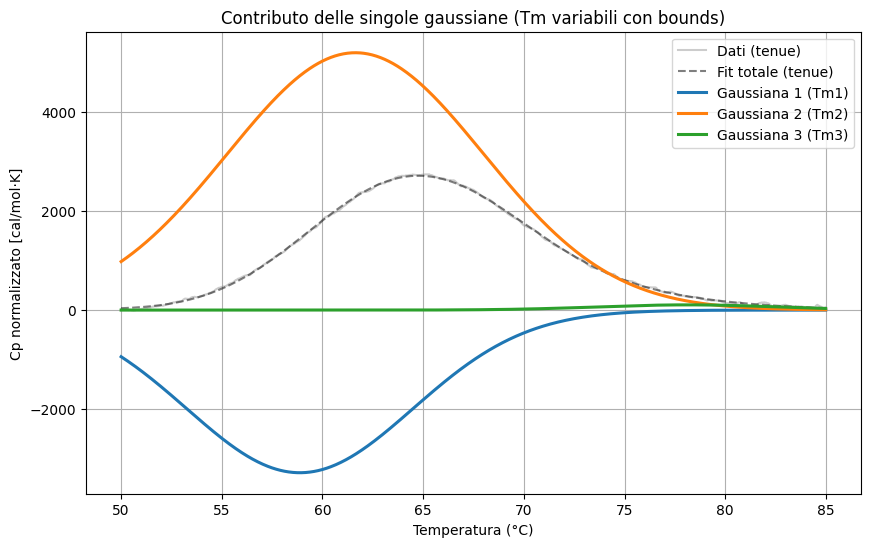

In [5]:
# === Singole gaussiane (fit con Tm variabili) ===
gauss1 = A1 * np.exp(-((T - Tm1_fit) ** 2) / (2 * sigma1 ** 2))
gauss2 = A2 * np.exp(-((T - Tm2_fit) ** 2) / (2 * sigma2 ** 2))
gauss3 = A3 * np.exp(-((T - Tm3_fit) ** 2) / (2 * sigma3 ** 2))
fit_totale = gauss1 + gauss2 + gauss3

# === Secondo plot: gaussiane in evidenza ===
plt.figure(figsize=(10,6))
plt.plot(T, Cp, color='gray', alpha=0.4, label='Dati (tenue)')
plt.plot(T, fit_totale, color='black', linestyle='--', alpha=0.5, label='Fit totale (tenue)')

plt.plot(T, gauss1, label='Gaussiana 1 (Tm1)', linewidth=2.2)
plt.plot(T, gauss2, label='Gaussiana 2 (Tm2)', linewidth=2.2)
plt.plot(T, gauss3, label='Gaussiana 3 (Tm3)', linewidth=2.2)

plt.xlabel('Temperatura (°C)')
plt.ylabel('Cp normalizzato [cal/mol·K]')
plt.title('Contributo delle singole gaussiane (Tm variabili con bounds)')
plt.legend()
plt.grid()
plt.show()


### Tm libere (non viene):

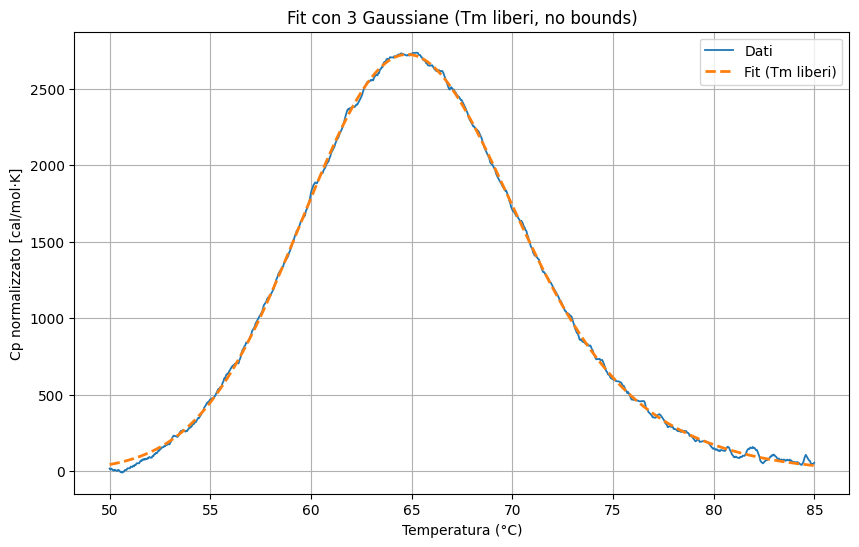

Tm1_fit = 70.71 °C
Tm2_fit = 64.34 °C
Tm3_fit = 93.85 °C

MAE (Tm liberi): 16.2290 cal/mol·K
MSE (Tm liberi): 424.8801 (cal/mol·K)^2
Chi² ridotto (Tm liberi): 429.4928


In [6]:
# === Dati ===
mask = (df_corr["Temperatura"] >= 50) & (df_corr["Temperatura"] <= 85)
T = df_corr["Temperatura"][mask].values
Cp = df_corr["Cp_finale_cubica"][mask].values

# === Funzione: somma di 3 gaussiane con Tm liberi ===
def triple_gaussian_totfree(T, A1_totfree, sigma1_totfree, Tm1_totfree, A2_totfree, sigma2_totfree, Tm2_totfree, A3_totfree, sigma3_totfree, Tm3_totfree):
    return (
        A1_totfree * np.exp(-((T - Tm1_totfree)**2) / (2 * sigma1_totfree**2)) +
        A2_totfree * np.exp(-((T - Tm2_totfree)**2) / (2 * sigma2_totfree**2)) +
        A3_totfree * np.exp(-((T - Tm3_totfree)**2) / (2 * sigma3_totfree**2))
    )

# === Initial guess dai risultati del fit con Tm fissi ===
def clamp(val, lo, hi, eps=1e-6):
    return max(min(val, hi - eps), lo + eps)

p0_totfree = [
    clamp(A1_f, 0, np.inf),
    clamp(sigma1_f, 0.1, np.inf),
    clamp(Tm1_C, Tm1_C - 5, np.inf),
    
    clamp(A2_f, 0, np.inf),
    clamp(sigma2_f, 0.1, np.inf),
    clamp(Tm2_C, Tm2_C - 5, np.inf),

    clamp(A3_f, 0, np.inf),
    clamp(sigma3_f, 0.1, np.inf),
    clamp(Tm3_C, Tm3_C - 5, np.inf)
]


# === Bounds non definiti per Tm liberi ===
lower_bounds = [0, 0.1, Tm1_C - 5, 0, 0.1, Tm2_C - 5, 0, 0.1, Tm3_C - 5]
upper_bounds = [np.inf]*9


# === Fit con Tm totalmente liberi ===
popt_totfree, pcov_totfree = curve_fit(
    triple_gaussian_totfree,
    T, Cp,
    p0=p0_totfree,
    bounds=(lower_bounds, upper_bounds),
    maxfev=2000
)


# === Parametri estratti ===
A1_totfree, sigma1_totfree, Tm1_totfree, A2_totfree, sigma2_totfree, Tm2_totfree, A3_totfree, sigma3_totfree, Tm3_totfree = popt_totfree

# === Predizione e metriche ===
Cp_fit_free = triple_gaussian_totfree(T, *popt_totfree)
residui_free = Cp - Cp_fit_free
dof_free = len(Cp) - len(popt_totfree)

mae_free = mean_absolute_error(Cp, Cp_fit_free)
mse_free = mean_squared_error(Cp, Cp_fit_free)
chi2_red_free = np.sum(residui_free**2) / dof_free

for i, (val, lo, hi) in enumerate(zip(p0_totfree, lower_bounds, upper_bounds)):
    if not (lo < val < hi):
        print(f"⚠️ p0[{i}] = {val:.4f} fuori da bounds ({lo:.4f}, {hi:.4f})")



# === Plot ===
plt.figure(figsize=(10,6))
plt.plot(T, Cp, label='Dati', linewidth=1.3)
plt.plot(T, Cp_fit_free, '--', label='Fit (Tm liberi)', linewidth=2)
plt.xlabel('Temperatura (°C)')
plt.ylabel('Cp normalizzato [cal/mol·K]')
plt.title('Fit con 3 Gaussiane (Tm liberi, no bounds)')
plt.legend()
plt.grid()
plt.show()

# === Stampa risultati ===
print(f"Tm1_fit = {Tm1_totfree:.2f} °C")
print(f"Tm2_fit = {Tm2_totfree:.2f} °C")
print(f"Tm3_fit = {Tm3_totfree:.2f} °C")
print(f"\nMAE (Tm liberi): {mae_free:.4f} cal/mol·K")
print(f"MSE (Tm liberi): {mse_free:.4f} (cal/mol·K)^2")
print(f"Chi² ridotto (Tm liberi): {chi2_red_free:.4f}")




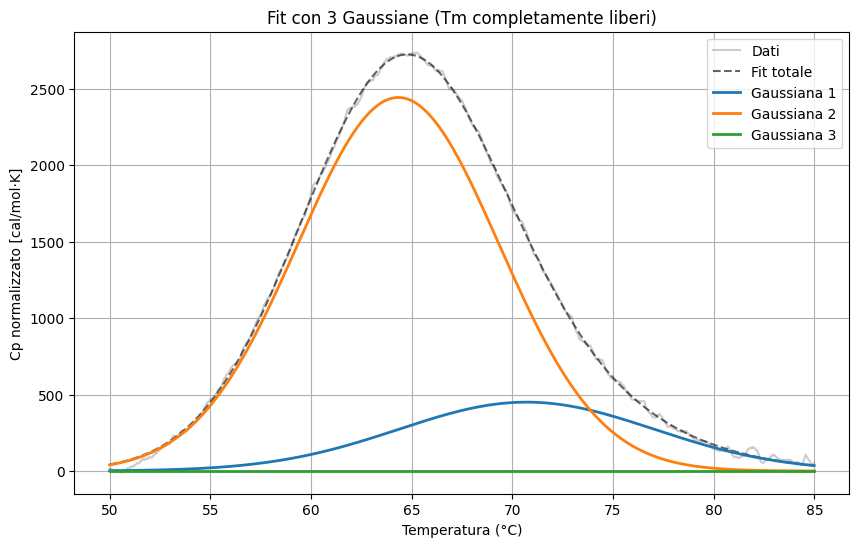

In [7]:
gauss1_totfree = A1_totfree * np.exp(-((T - Tm1_totfree)**2) / (2 * sigma1_totfree**2))
gauss2_totfree = A2_totfree * np.exp(-((T - Tm2_totfree)**2) / (2 * sigma2_totfree**2))
gauss3_totfree = A3_totfree * np.exp(-((T - Tm3_totfree)**2) / (2 * sigma3_totfree**2))

plt.figure(figsize=(10,6))
plt.plot(T, Cp, color='gray', alpha=0.4, label='Dati')
plt.plot(T, Cp_fit_free, '--', color='black', alpha=0.6, label='Fit totale')

plt.plot(T, gauss1_totfree, label='Gaussiana 1', linewidth=2)
plt.plot(T, gauss2_totfree, label='Gaussiana 2', linewidth=2)
plt.plot(T, gauss3_totfree, label='Gaussiana 3', linewidth=2)

plt.xlabel('Temperatura (°C)')
plt.ylabel('Cp normalizzato [cal/mol·K]')
plt.title('Fit con 3 Gaussiane (Tm completamente liberi)')
plt.legend()
plt.grid()
plt.show()


# Fit Campione c3 con baseline cubica a più componenti, secondo i risultati di SVD con Gauss positive:

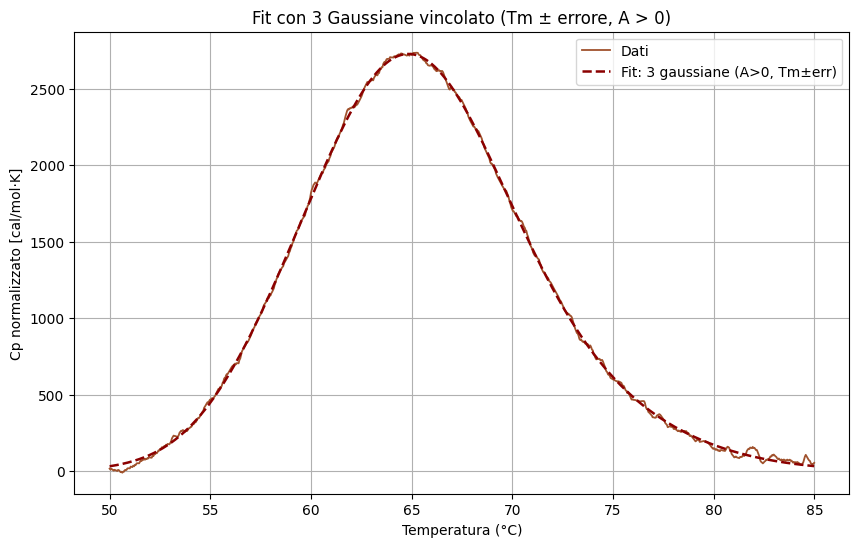

Tm1 = 57.89 °C 
Tm2 = 64.35 °C 
Tm3 = 69.94 °C 

MAE: 14.90 cal/mol·K
MSE: 356.81 (cal/mol·K)^2
Chi² ridotto: 360.6811
Chi² vero normalizzato (idealmente ≈ 1): 1.0115


In [8]:
# === Conversione Tm e incertezze da K a °C ===
Tm1_C_true, err1_true = 329.46843033838434 - 273.15, 2.5584027780087473
Tm2_C_true, err2_true = 334.4127568316971  - 273.15, 0.37382475660932163
Tm3_C_true, err3_true = 352.6269312480101  - 273.15, 1.385632121088951

# === Funzione: somma di 3 gaussiane ===
def triple_gaussian_true(T, A1, sigma1, Tm1, A2, sigma2, Tm2, A3, sigma3, Tm3):
    return (
        A1 * np.exp(-((T - Tm1)**2) / (2 * sigma1**2)) +
        A2 * np.exp(-((T - Tm2)**2) / (2 * sigma2**2)) +
        A3 * np.exp(-((T - Tm3)**2) / (2 * sigma3**2))
    )

# === Dati ===
mask_true = (df_corr["Temperatura"] >= 50) & (df_corr["Temperatura"] <= 85)
T_true = df_corr["Temperatura"][mask_true].values
Cp_true = df_corr["Cp_finale_cubica"][mask_true].values

# === Guess iniziali presi dal fit della tutor ===
A1_f_true, sigma1_f_true = 2500, 6.0
A2_f_true, sigma2_f_true = 22000, 8.5
A3_f_true, sigma3_f_true = 11700, 10.8

# === Initial guess ===
p0_true = [
    A1_f_true, sigma1_f_true, Tm1_C_true,
    A2_f_true, sigma2_f_true, Tm2_C_true,
    A3_f_true, sigma3_f_true, Tm3_C_true
]

# === Bounds (A > 0, sigma > 0, Tm ± err) ===
lower_bounds_true = [
    0, 0, 56 ,
    0, 0, Tm2_C_true - 10,
    0, 0, Tm3_C_true - 10
]

upper_bounds_true = [
    np.inf, np.inf, Tm1_C_true + 10,
    np.inf, np.inf, Tm2_C_true + 10,
    np.inf, np.inf, 80
]

# === Fit ===
popt_true, pcov_true = curve_fit(
    triple_gaussian_true,
    T_true, Cp_true,
    p0=p0_true,
    bounds=(lower_bounds_true, upper_bounds_true),
    maxfev=20000
)

# === Parametri estratti ===
A1_true, sigma1_true, Tm1_fit_true, A2_true, sigma2_true, Tm2_fit_true, A3_true, sigma3_true, Tm3_fit_true = popt_true

# === Predizione e metriche ===
Cp_fit_true = triple_gaussian_true(T_true, *popt_true)
mae_true = mean_absolute_error(Cp_true, Cp_fit_true)
mse_true = mean_squared_error(Cp_true, Cp_fit_true)
residui_true = Cp_true - Cp_fit_true
dof_true = len(Cp_true) - len(popt_true)
chi2_red_true = np.sum(residui_true**2) / dof_true

# === Plot ===
plt.figure(figsize=(10,6))
plt.plot(T_true, Cp_true, label='Dati', linewidth=1.3, color='sienna')
plt.plot(T_true, Cp_fit_true, '--', label='Fit: 3 gaussiane (A>0, Tm±err)', linewidth=1.8, color='darkred')
plt.xlabel('Temperatura (°C)')
plt.ylabel('Cp normalizzato [cal/mol·K]')
plt.title('Fit con 3 Gaussiane vincolato (Tm ± errore, A > 0)')
plt.legend()
plt.grid()
plt.show()

# === Stampa risultati ===
print(f"Tm1 = {Tm1_fit_true:.2f} °C ")
print(f"Tm2 = {Tm2_fit_true:.2f} °C ")
print(f"Tm3 = {Tm3_fit_true:.2f} °C ")
print(f"\nMAE: {mae_true:.2f} cal/mol·K")
print(f"MSE: {mse_true:.2f} (cal/mol·K)^2")
print(f"Chi² ridotto: {chi2_red_true:.4f}")

# === Calcolo chi² normalizzato (vero) ===
std_residui_true = np.std(residui_true)
chi2_true = np.sum((residui_true / std_residui_true)**2)
chi2_true_normalized = chi2_true / dof_true

# === Stampa anche il vero chi² normalizzato ===
print(f"Chi² vero normalizzato (idealmente ≈ 1): {chi2_true_normalized:.4f}")



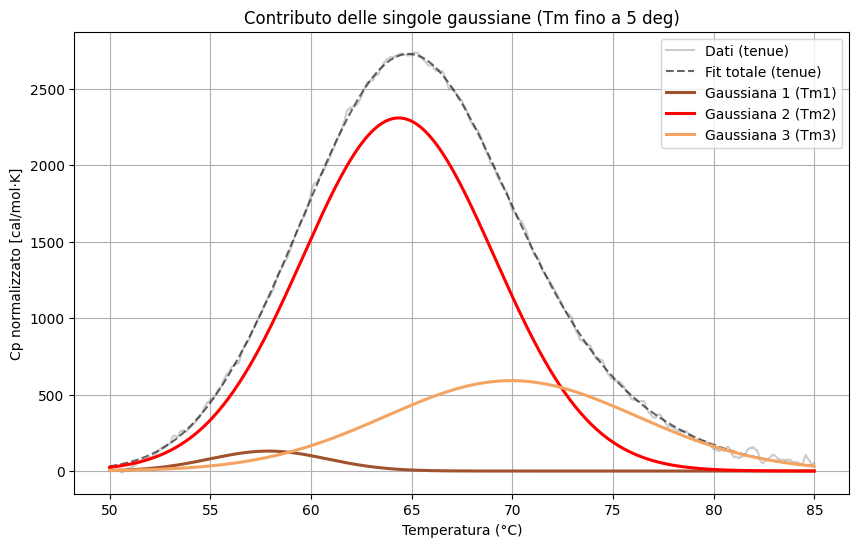

In [9]:
plt.figure(figsize=(10,6))
# === Singole gaussiane (fit con Tm vincolati) ===
gauss1_true = A1_true * np.exp(-((T_true - Tm1_fit_true) ** 2) / (2 * sigma1_true ** 2))
gauss2_true = A2_true * np.exp(-((T_true - Tm2_fit_true) ** 2) / (2 * sigma2_true ** 2))
gauss3_true = A3_true * np.exp(-((T_true - Tm3_fit_true) ** 2) / (2 * sigma3_true ** 2))
plt.plot(T_true, Cp_true, color='gray', alpha=0.4, label='Dati (tenue)')
plt.plot(T_true, Cp_fit_true, '--', color='black', alpha=0.6, label='Fit totale (tenue)')
plt.plot(T_true, gauss1_true, label='Gaussiana 1 (Tm1)', linewidth=2.2, color='sienna')
plt.plot(T_true, gauss2_true, label='Gaussiana 2 (Tm2)', linewidth=2.2, color ='red')
plt.plot(T_true, gauss3_true, label='Gaussiana 3 (Tm3)', linewidth=2.2, color='sandybrown')
plt.xlabel('Temperatura (°C)')
plt.ylabel('Cp normalizzato [cal/mol·K]')
plt.title('Contributo delle singole gaussiane (Tm fino a 5 deg)')
plt.legend()
plt.grid()
plt.show()



# Fit a due componenti: stato Folded e Unfolded

## Stima della temperatura di melting $ T_m $ mediante fit analitico con la funzione di Van't Hoff

Per ottenere una stima accurata della temperatura di melting $ T_m $, il tratto di picco del segnale $ C_p(T) $ è stato fittato utilizzando una forma semplificata della **funzione di Van’t Hoff**, particolarmente adatta a descrivere transizioni cooperative tra due stati.

La funzione utilizzata per il fit è:

$$
C_p(T) = \frac{A}{\cosh^2\left( \frac{T - T_m}{b} \right)}
$$

dove:
- $ A $ è un parametro proporzionale all’altezza massima del picco,
- $ T_m $ è la temperatura di melting (valore centrale della transizione),
- $ b $ è un parametro legato alla larghezza della transizione.

Questa funzione deriva da una formulazione del calore specifico per una transizione a due stati ed è in grado di catturare la forma tipica dei picchi di unfolding proteico o nucleico.

Il fit è stato effettuato per ciascun campione, e la stima di $ T_m $ ottenuta è stata poi utilizzata nel calcolo dell’entalpia di Van’t Hoff.


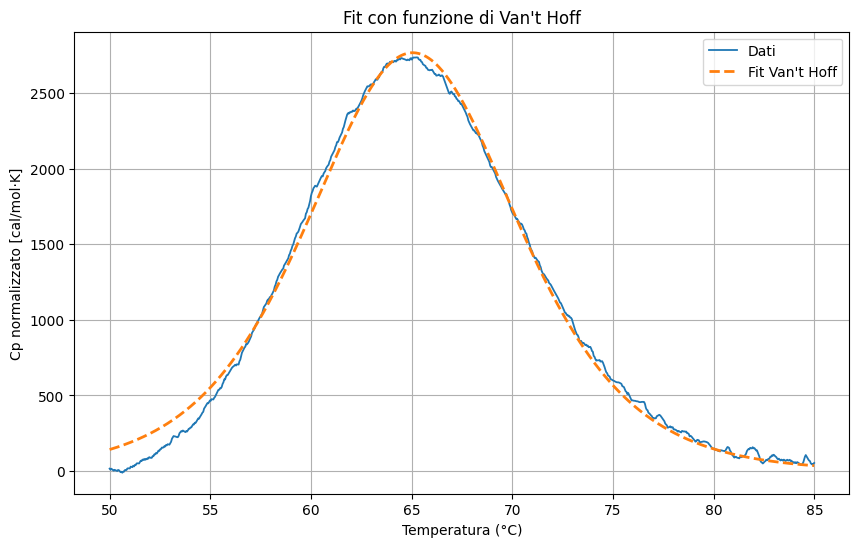

Tm_van = 65.05 °C

MAE (Van't Hoff): 53.6243 cal/mol·K
MSE (Van't Hoff): 4787.6642 (cal/mol·K)^2
Chi² ridotto (Van't Hoff): 4804.8654


In [10]:
# Funzione di van’t Hoff
def vanthoff_model(T, A, Tm, b):
    return A / np.cosh((T - Tm) / b)**2

# === Dati ===
mask = (df_corr["Temperatura"] >= 50) & (df_corr["Temperatura"] <= 85)
T = df_corr["Temperatura"][mask].values
Cp = df_corr["Cp_finale_cubica"][mask].values

# === Fit con Van't Hoff ===
popt, pcov = curve_fit(vanthoff_model, T, Cp, p0=[2000, 60, 2], maxfev=20000)

# === Parametri ottimizzati ===
A_van, Tm_van, b_van = popt

# === Predizione e metriche ===
Cp_fit_van = vanthoff_model(T, *popt)
mae_van = mean_absolute_error(Cp, Cp_fit_van)
mse_van = mean_squared_error(Cp, Cp_fit_van)

# === Chi quadro ridotto ===
residui_van = Cp - Cp_fit_van
dof_van = len(Cp) - len(popt)  # N - p
chi2_red_van = np.sum(residui_van**2) / dof_van

# === Plot ===
plt.figure(figsize=(10,6))
plt.plot(T, Cp, label='Dati', linewidth=1.3)
plt.plot(T, Cp_fit_van, '--', label='Fit Van\'t Hoff', linewidth=2)
plt.xlabel('Temperatura (°C)')
plt.ylabel('Cp normalizzato [cal/mol·K]')
plt.title('Fit con funzione di Van\'t Hoff')
plt.legend()
plt.grid()
plt.show()

# === Stampa risultati ===
print(f"Tm_van = {Tm_van:.2f} °C")
print(f"\nMAE (Van't Hoff): {mae_van:.4f} cal/mol·K")
print(f"MSE (Van't Hoff): {mse_van:.4f} (cal/mol·K)^2")
print(f"Chi² ridotto (Van't Hoff): {chi2_red_van:.4f}")


## Fit con una sola funzione Gaussiana:
La funzione adottata per il fit è la seguente:

$$
C_p(T) = A \cdot \exp\left( -\frac{(T - T_m)^2}{2\sigma^2} \right)
$$

dove:
- $A$ è l’ampiezza massima del picco;
- $T_m$ rappresenta la temperatura alla quale il picco raggiunge il massimo, quindi una stima della temperatura di melting;
- $\sigma$ controlla la larghezza della distribuzione, ed è collegata alla cooperatività della transizione.


Questa forma gaussiana non ha un legame diretto con un modello termodinamico, ma permette una \textit{stima veloce e robusta del massimo termico}, utile per confronti qualitativi tra campioni o per inizializzare modelli più complessi.

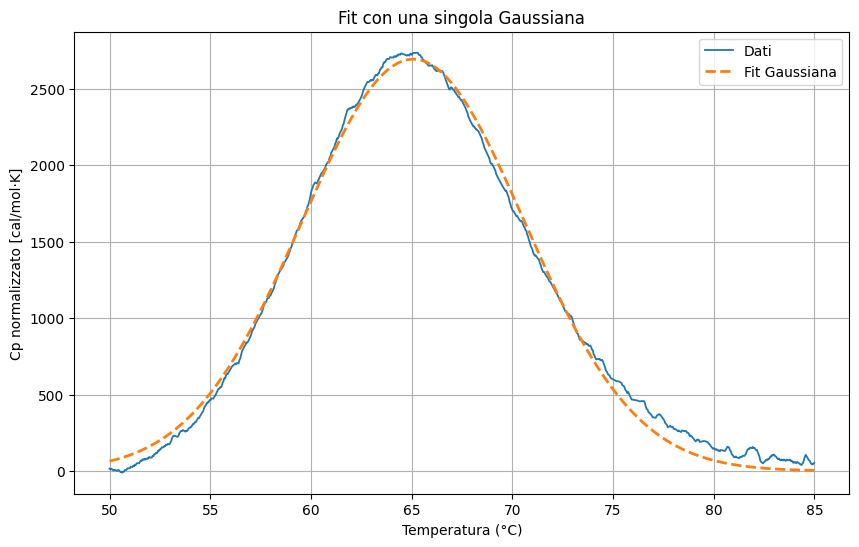

Tm_gauss = 65.08 °C

MAE (Gaussiana): 58.0120 cal/mol·K
MSE (Gaussiana): 4397.9747 (cal/mol·K)^2
Chi² ridotto (Gaussiana): 4413.7758


In [11]:
# Funzione gaussiana per Cp(T)
def gaussian_model(T, A, Tm, sigma):
    return A * np.exp(-((T - Tm)**2) / (2 * sigma**2))

# === Fit con una singola Gaussiana ===
popt_gauss, pcov_gauss = curve_fit(gaussian_model, T, Cp, p0=[2000, 60, 2], maxfev=20000)

# === Parametri ottimizzati ===
A_gauss, Tm_gauss, sigma_gauss = popt_gauss

# === Predizione e metriche ===
Cp_fit_gauss = gaussian_model(T, *popt_gauss)
mae_gauss = mean_absolute_error(Cp, Cp_fit_gauss)
mse_gauss = mean_squared_error(Cp, Cp_fit_gauss)

# === Chi quadro ridotto ===
residui_gauss = Cp - Cp_fit_gauss
dof_gauss = len(Cp) - len(popt_gauss)  # N - p
chi2_red_gauss = np.sum(residui_gauss**2) / dof_gauss

# === Plot ===
plt.figure(figsize=(10,6))
plt.plot(T, Cp, label='Dati', linewidth=1.3)
plt.plot(T, Cp_fit_gauss, '--', label='Fit Gaussiana', linewidth=2)
plt.xlabel('Temperatura (°C)')
plt.ylabel('Cp normalizzato [cal/mol·K]')
plt.title('Fit con una singola Gaussiana')
plt.legend()
plt.grid()
plt.show()

# === Stampa risultati ===
print(f"Tm_gauss = {Tm_gauss:.2f} °C")
print(f"\nMAE (Gaussiana): {mae_gauss:.4f} cal/mol·K")
print(f"MSE (Gaussiana): {mse_gauss:.4f} (cal/mol·K)^2")
print(f"Chi² ridotto (Gaussiana): {chi2_red_gauss:.4f}")


# Confronto tra i risultati:
Dalla valutazione degli errori di fit è evidente che il modello a 3 stati si comporta meglio e riesce in maniera più pulita a riprodurre bene i dati di nanoDSC.

# Calcolo dei parametri termodinamici:

## Considerazioni sugli errori:

In [ ]:


# Inizializza dizionario
ci_finali_data = {}

# Caricamento
for filename in sorted(os.listdir(folder_path1), key=natural_key):
    if filename == "c3_cubica.csv":
        path = folder_path1 / "c3_cubica.csv"
        df = pd.read_csv(path, sep="\t")
        ci_finali_data[filename.replace(".csv", "")] = df

# Mostra le anteprime (primi 5 file)
for nome, df in list(ci_finali_data.items())[:5]:
    print(f"\n--- {nome} ---")
    display(df.head())


--- c3_cubica ---


,Temperatura,Cp_corretto,Cp_baseline,Cp_finale_cubica
0,41.937,-2004.326385,-2220.791659,216.465274
1,41.979,-2004.818889,-2216.089230,211.270341
2,42.021,-2005.311393,-2211.400360,206.088967
3,42.064,-2015.451104,-2206.613879,191.162774
4,42.106,-2010.980154,-2201.952397,190.972244



--- c3_gradino ---


,Temperatura,Cp_corretto,Cp_baseline,Cp_finale_gradino
0,46.117,-1800.533137,-1618.306097,-182.227039
1,46.159,-1798.235380,-1618.306097,-179.929282
2,46.201,-1795.937623,-1618.306097,-177.631525
3,46.242,-1792.424733,-1618.306097,-174.118636
4,46.284,-1792.084396,-1618.306097,-173.778299



--- c3_lineare ---


,Temperatura,Cp_corretto,Cp_baseline,Cp_finale_lineare
0,46.117,-1800.533137,-1510.933473,-289.599664
1,46.159,-1798.235380,-1510.932663,-287.302716
2,46.201,-1795.937623,-1510.931854,-285.005769
3,46.242,-1792.424733,-1510.931064,-281.493669
4,46.284,-1792.084396,-1510.930254,-281.154142



--- c3_sigmoide ---


,Temperatura,Cp_corretto,Cp_baseline,Cp_finale_sigmoide
0,49.459,-1618.877387,-1618.264906,-0.612481
1,49.502,-1618.297206,-1618.265433,-0.031772
2,49.544,-1605.803680,-1618.265943,12.462262
3,49.586,-1593.310154,-1618.266445,24.956291
4,49.627,-1590.256951,-1618.266930,28.009979


In [13]:
from ipywidgets import interact, Dropdown

def plot_dsc_interattivo(dati_dict, colonna_cp_prefix="Cp_finale"):
    """
    Visualizza interattivamente i dati DSC con Cp finale e visualizzazione del picco.
    
    Parameters:
    - dati_dict: dizionario tipo {"c3_cubica": DataFrame, ...}
    - colonna_cp_prefix: prefisso della colonna Cp finale, default = 'Cp_finale'
    """
    opzioni = sorted(dati_dict.keys())

    @interact(dataset=Dropdown(options=opzioni, description='Campione:'))
    def _plot(dataset):
        df = dati_dict[dataset]
        baseline = dataset.split("_")[-1]
        col_cp = f'{colonna_cp_prefix}_{baseline}'
        
        T = df['Temperatura']
        Cp = df[col_cp]

        plt.figure(figsize=(8, 5))
        plt.plot(T, Cp, label=f'{dataset}', color='darkred')
        plt.title(f'DSC - {dataset}')
        plt.xlabel('Temperatura (°C)')
        plt.ylabel('Heat Capacity (cal/mol·°C)')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()


plot_dsc_interattivo(ci_finali_data)


interactive(children=(Dropdown(description='Campione:', options=('c3_cubica', 'c3_gradino', 'c3_lineare', 'c3_…

Per ciascun campione è stato integrato il calore specifico corretto, usando:

$$
\Delta H = \int_{T_{min}}^{T_{max}} C_p(T) \, dT
$$

La procedura è ripetuta per 4 diversi modelli di baseline: lineare, cubica, a gradino e sigmoide.

Per stimare l'incertezza legata alla scelta del modello di baseline, viene calcolata la **deviazione standard** dei valori di ΔH ottenuti con le diverse baseline, assumendo che il contributo maggiore all'errore sia proprio legato a questa scelta.


In [ ]:
records = []  # (Campione, Baseline, DeltaH)

for name in sorted(ci_finali_data, key=natural_key):
    df = ci_finali_data[name]
    campione, baseline = name.split("_", 1)

    # Trova colonna con Cp finale
    col_cp = [c for c in df.columns if c.startswith("Cp_finale")][0]
    T = df["Temperatura"].values
    Cp = df[col_cp].values

    delta_H = np.trapezoid(Cp, T)
    records.append((campione, baseline, delta_H))

df_DH = pd.DataFrame(records, columns=["Campione", "Baseline", "DeltaH"])

# === 3. Calcolo errore tra baseline ===========
df_std = df_DH.groupby("Campione")["DeltaH"].std().rename("Errore_baseline")
df_DH = df_DH.merge(df_std, on="Campione").sort_values(["Campione", "Baseline"])

# === 4. Output ================================
pd.set_option("display.precision", 6)
print(df_DH.to_string(index=False))


In [15]:
# --- Estrai ΔH e errore per la baseline cubica di c3 ---
DH_cubica = df_DH.loc[(df_DH["Campione"] == "c3") & (df_DH["Baseline"] == "cubica"), "DeltaH"].values[0]
err_DH_cubica = df_DH.loc[(df_DH["Campione"] == "c3") & (df_DH["Baseline"] == "cubica"), "Errore_baseline"].values[0]

# --- Stampa per controllo ---
print(f"ΔH (cubica, c3): {DH_cubica:.2f} cal/mol")
print(f"Errore su ΔH: {err_DH_cubica:.2f} cal/mol")


ΔH (cubica, c3): 38113.47 cal/mol
Errore su ΔH: 4209.43 cal/mol


## Costruzione dataframe:

### Valutazione dell’incertezza su *T*<sub>m</sub>

L’errore riportato nella colonna **σ<sub>Tₘ</sub>** è la deviazione standard (1 σ)
associata al parametro *T*<sub>m</sub> del fit con la funzione di van’t Hoff.

`scipy.optimize.curve_fit` restituisce la matrice di covarianza `pcov` dei parametri
ottimizzati; l’elemento `pcov[1, 1]` è la varianza stimata di *T*<sub>m</sub>.
Da qui:

$$
\sigma_{T_m} \;=\; \sqrt{\text{pcov}[1,1]}
$$

Questa stima assume:
1. residui gaussiani indipendenti e identicamente distribuiti,  
2. linearizzazione locale del modello intorno al minimo del χ².  

Per misure nanoDSC con buon rapporto segnale/rumore ciò fornisce
incertezze tipiche di **0,05 – 0,20 °C**.  
Se i residui mostrano forte eteroschedasticità o autocorrelazione la
deviazione standard potrebbe essere sottostimata; in tal caso si può
ricorrere a bootstrap dei residui o a un’analisi Monte Carlo, ma per i
dati presenti la stima da `pcov` è considerata adeguata.


In [16]:
# === Estrai gli errori sulle Tm dalla matrice di covarianza ===
# Tm1 = parametro 2, Tm2 = parametro 5, Tm3 = parametro 8
sigma_Tm1_fit = np.sqrt(pcov_true[2, 2])
sigma_Tm2_fit = np.sqrt(pcov_true[5, 5])
sigma_Tm3_fit = np.sqrt(pcov_true[8, 8])

# === Crea il DataFrame finale ===
df_finale = pd.DataFrame({
    "Modello": ["triple_gauss_cubica"],
    "ΔH (cal/mol) 2 states": [DH_cubica],  # ← lo avevi già calcolato
    "σ_ΔH (cal/mol)": [err_DH_cubica],  # ← errore baseline, se stimato
    "Tm1 (°C)": [Tm1_fit_true],
    "σ_Tm1 (°C)": [sigma_Tm1_fit],
    "Tm2 (°C)": [Tm2_fit_true],
    "σ_Tm2 (°C)": [sigma_Tm2_fit],
    "Tm3 (°C)": [Tm3_fit_true],
    "σ_Tm3 (°C)": [sigma_Tm3_fit],
})

# Arrotonda per chiarezza
df_finale = df_finale.round(2)

# Visualizza
display(df_finale.style.hide(axis="index"))


Modello,ΔH (cal/mol) 2 states,σ_ΔH (cal/mol),Tm1 (°C),σ_Tm1 (°C),Tm2 (°C),σ_Tm2 (°C),Tm3 (°C),σ_Tm3 (°C)
triple_gauss_cubica,38113.470000,4209.430000,57.890000,0.400000,64.350000,0.090000,69.940000,3.210000


#### Incertezza su *T*<sub>m</sub>

L’incertezza totale riportata nella colonna **σ<sub>Tₘ</sub> (°C)** combina:

1. **Errore di fit**  
   $ \sigma_{T_m,\text{fit}} $ ricavato dalla radice della varianza del parametro *T*<sub>m</sub>  
   (elemento `pcov[1, 1]`) fornita da `curve_fit`.

2. **Errore termico dello strumento**  
   TA Instruments specifica per il Nano DSC una stabilità di baseline di ±0.028 µW e un controllo termico a stato solido che garantisce precisione < 0.2 °C :contentReference[oaicite:0]{index=0}.  
   Abbiamo quindi aggiunto **±0.2 °C** in quadratura:


$$
\sigma_{T_{m,\text{tot}}} = \left( \sigma_{T_{m,\text{fit}}}^2 + 0.2 \right)^{1/2}
$$

Questa procedura fornisce un errore **assoluto** su *T*<sub>m</sub>, che include sia la precisione numerica del fit sia la tolleranza termica dichiarata dal produttore.


In [17]:
# === Aggiungi errore strumentale ±0.2 °C in quadratura ===
df_finale["σ_Tm1 (°C)"] = np.sqrt(df_finale["σ_Tm1 (°C)"]**2 + 0.2**2)
df_finale["σ_Tm2 (°C)"] = np.sqrt(df_finale["σ_Tm2 (°C)"]**2 + 0.2**2)
df_finale["σ_Tm3 (°C)"] = np.sqrt(df_finale["σ_Tm3 (°C)"]**2 + 0.2**2)

# (facoltativo) arrotonda
df_finale = df_finale.round(3)

# Visualizza il DataFrame finale con gli errori strumentali
display(df_finale.style.hide(axis="index"))


Modello,ΔH (cal/mol) 2 states,σ_ΔH (cal/mol),Tm1 (°C),σ_Tm1 (°C),Tm2 (°C),σ_Tm2 (°C),Tm3 (°C),σ_Tm3 (°C)
triple_gauss_cubica,38113.470000,4209.430000,57.890000,0.447000,64.350000,0.219000,69.940000,3.216000


#### Calcolo di entropia e Gibbs libera

L’entropia di transizione è stata ottenuta **integrando la curva DSC**,
secondo l’equazione:

$$
\Delta S(T_m)=\int_{T_i}^{T_f}\frac{C_p(T)}{T}\,dT
$$

mentre l’energia libera di Gibbs a 298 K è:

$$
\Delta G_{298}=\Delta H_{cal}-T_{\mathrm{ref}}\;\Delta S(T_m)
$$

dove $ T_{\mathrm{ref}}=298.15 \text{ K} $.  
Entrambe le relazioni sono riportate da Pagano et al. (METHODS 64, 43–51, 2013) :contentReference[oaicite:2]{index=2}.

**Propagazione degli errori**

* $ σ_{\Delta H} $ – deviazione standard dovuta alla scelta della baseline  
* $ σ_{\Delta S} $ – analoga SD calcolata su ΔS tra le quattro baseline  

$
\sigma_{\Delta G}^2=\sigma_{\Delta H}^2+\bigl(T_{\mathrm{ref}}\;\sigma_{\Delta S}\bigr)^2
$

Le colonne aggiunte ($ ΔS, σ_{ΔS}, ΔG_{298K}, σ_{ΔG, 298K}, ΔG_{310K}, σ_{ΔG,310K} $) sono ora presenti
nel dataframe finale.


In [18]:
# === Costanti ===
T_REF1 = 298.15
T_REF2 = 310.15
sqrt_2pi = np.sqrt(2 * np.pi)

# === Estrai parametri dal fit triplo ===
A1, sigma1, Tm1 = popt_true[0], popt_true[1], popt_true[2]
A2, sigma2, Tm2 = popt_true[3], popt_true[4], popt_true[5]
A3, sigma3, Tm3 = popt_true[6], popt_true[7], popt_true[8]

# === ΔH = integrale della singola gaussiana ===
DH1 = A1 * sigma1 * sqrt_2pi
DH2 = A2 * sigma2 * sqrt_2pi
DH3 = A3 * sigma3 * sqrt_2pi

# === ΔS = integrale Cp/T (su gaussiana) ===
# Per ciascuna curva Cp_i(T), calcoliamo Cp_i(T)/T e integriamo

T_fit = np.linspace(50, 85, 1000)
Cp1 = A1 * np.exp(-((T_fit - Tm1)**2) / (2 * sigma1**2))
Cp2 = A2 * np.exp(-((T_fit - Tm2)**2) / (2 * sigma2**2))
Cp3 = A3 * np.exp(-((T_fit - Tm3)**2) / (2 * sigma3**2))

T_fit_K = T_fit + 273.15

DS1 = np.trapezoid(Cp1 / T_fit_K, T_fit_K)
DS2 = np.trapezoid(Cp2 / T_fit_K, T_fit_K)
DS3 = np.trapezoid(Cp3 / T_fit_K, T_fit_K)

# === ΔG a 298 K ===
DG1_298 = DH1 - T_REF1 * DS1
DG2_298 = DH2 - T_REF1 * DS2
DG3_298 = DH3 - T_REF1 * DS3

# === ΔG a 310 K ===
DG1_310 = DH1 - T_REF2 * DS1
DG2_310 = DH2 - T_REF2 * DS2
DG3_310 = DH3 - T_REF2 * DS3

# === Inserisci nel DataFrame ===
df_finale["ΔH1 (cal/mol)"] = DH1
df_finale["ΔH2 (cal/mol)"] = DH2
df_finale["ΔH3 (cal/mol)"] = DH3

df_finale["ΔS1 (cal/mol·K)"] = DS1
df_finale["ΔS2 (cal/mol·K)"] = DS2
df_finale["ΔS3 (cal/mol·K)"] = DS3

df_finale["ΔG1_298 (cal/mol)"] = DG1_298
df_finale["ΔG2_298 (cal/mol)"] = DG2_298
df_finale["ΔG3_298 (cal/mol)"] = DG3_298

df_finale["ΔG1_310 (cal/mol)"] = DG1_310
df_finale["ΔG2_310 (cal/mol)"] = DG2_310
df_finale["ΔG3_310 (cal/mol)"] = DG3_310

# === Visualizza risultato finale ===
df_finale = df_finale.round(2)
display(df_finale.style.hide(axis="index"))


Modello,ΔH (cal/mol) 2 states,σ_ΔH (cal/mol),Tm1 (°C),σ_Tm1 (°C),Tm2 (°C),σ_Tm2 (°C),Tm3 (°C),σ_Tm3 (°C),ΔH1 (cal/mol),ΔH2 (cal/mol),ΔH3 (cal/mol),ΔS1 (cal/mol·K),ΔS2 (cal/mol·K),ΔS3 (cal/mol·K),ΔG1_298 (cal/mol),ΔG2_298 (cal/mol),ΔG3_298 (cal/mol),ΔG1_310 (cal/mol),ΔG2_310 (cal/mol),ΔG3_310 (cal/mol)
triple_gauss_cubica,38113.470000,4209.430000,57.890000,0.450000,64.350000,0.220000,69.940000,3.220000,956.470000,27527.230000,9237.700000,2.880000,81.470000,26.710000,98.020000,3237.520000,1273.440000,63.470000,2259.900000,952.890000


### Propagazione dell’errore da ΔH a ΔS e ΔG

Per ciascuna delle tre transizioni identificate, l’incertezza su ΔH è stata stimata **a partire dalla variabilità dovuta alla scelta della baseline**.  
Abbiamo calcolato un **errore relativo**:

$$
\varepsilon_{\Delta H} = \frac{\sigma_{\Delta H,\text{baseline}}}{\Delta H}
$$

e lo abbiamo applicato anche a:

- ΔH<sub>i</sub> (area sotto la i-esima gaussiana),
- ΔS<sub>i</sub> (integrale Cp/T),
- ΔG<sub>i</sub> = ΔH<sub>i</sub> – T·ΔS<sub>i</sub>.

Le incertezze su ΔG sono quindi state propagate secondo:

$$
\sigma_{\Delta G_i} = \sqrt{\sigma_{\Delta H_i}^2 + \left( T \cdot \sigma_{\Delta S_i} \right)^2}
$$

Questa procedura permette di **trasferire coerentemente l’incertezza sistematica** dovuta alla baseline anche alle quantità derivate, garantendo una stima affidabile degli errori su ΔS e ΔG.


In [19]:
df_DH["Errore_baseline_rel"] = df_DH["Errore_baseline"] / df_DH["DeltaH"]

# Applica errore relativo anche alle 3 aree gaussiane
err_rel = df_DH.loc[(df_DH["Campione"] == "c3") & (df_DH["Baseline"] == "cubica"), "Errore_baseline_rel"].values[0]

# Calcola errore assoluto propagato su ΔH
df_finale["σ_ΔH1 (cal/mol)"] = df_finale["ΔH1 (cal/mol)"] * err_rel
df_finale["σ_ΔH2 (cal/mol)"] = df_finale["ΔH2 (cal/mol)"] * err_rel
df_finale["σ_ΔH3 (cal/mol)"] = df_finale["ΔH3 (cal/mol)"] * err_rel

df_finale["σ_ΔS1 (cal/mol·K)"] = df_finale["ΔS1 (cal/mol·K)"] * err_rel
df_finale["σ_ΔS2 (cal/mol·K)"] = df_finale["ΔS2 (cal/mol·K)"] * err_rel
df_finale["σ_ΔS3 (cal/mol·K)"] = df_finale["ΔS3 (cal/mol·K)"] * err_rel

T1 = 298.15
T2 = 310.15

df_finale["σ_ΔG1_298"] = np.sqrt(df_finale["σ_ΔH1 (cal/mol)"]**2 + (T1 * df_finale["σ_ΔS1 (cal/mol·K)"])**2)
df_finale["σ_ΔG2_298"] = np.sqrt(df_finale["σ_ΔH2 (cal/mol)"]**2 + (T1 * df_finale["σ_ΔS2 (cal/mol·K)"])**2)
df_finale["σ_ΔG3_298"] = np.sqrt(df_finale["σ_ΔH3 (cal/mol)"]**2 + (T1 * df_finale["σ_ΔS3 (cal/mol·K)"])**2)

df_finale["σ_ΔG1_310"] = np.sqrt(df_finale["σ_ΔH1 (cal/mol)"]**2 + (T2 * df_finale["σ_ΔS1 (cal/mol·K)"])**2)
df_finale["σ_ΔG2_310"] = np.sqrt(df_finale["σ_ΔH2 (cal/mol)"]**2 + (T2 * df_finale["σ_ΔS2 (cal/mol·K)"])**2)
df_finale["σ_ΔG3_310"] = np.sqrt(df_finale["σ_ΔH3 (cal/mol)"]**2 + (T2 * df_finale["σ_ΔS3 (cal/mol·K)"])**2)

# === Visualizza il DataFrame finale con gli errori propagati ===
df_finale = df_finale.round(3)
display(df_finale.style.hide(axis="index"))


Modello,ΔH (cal/mol) 2 states,σ_ΔH (cal/mol),Tm1 (°C),σ_Tm1 (°C),Tm2 (°C),σ_Tm2 (°C),Tm3 (°C),σ_Tm3 (°C),ΔH1 (cal/mol),ΔH2 (cal/mol),ΔH3 (cal/mol),ΔS1 (cal/mol·K),ΔS2 (cal/mol·K),ΔS3 (cal/mol·K),ΔG1_298 (cal/mol),ΔG2_298 (cal/mol),ΔG3_298 (cal/mol),ΔG1_310 (cal/mol),ΔG2_310 (cal/mol),ΔG3_310 (cal/mol),σ_ΔH1 (cal/mol),σ_ΔH2 (cal/mol),σ_ΔH3 (cal/mol),σ_ΔS1 (cal/mol·K),σ_ΔS2 (cal/mol·K),σ_ΔS3 (cal/mol·K),σ_ΔG1_298,σ_ΔG2_298,σ_ΔG3_298,σ_ΔG1_310,σ_ΔG2_310,σ_ΔG3_310
triple_gauss_cubica,38113.470000,4209.430000,57.890000,0.450000,64.350000,0.220000,69.940000,3.220000,956.470000,27527.230000,9237.700000,2.880000,81.470000,26.710000,98.020000,3237.520000,1273.440000,63.470000,2259.900000,952.890000,105.637000,3040.237000,1020.255000,0.318000,8.998000,2.950000,141.961000,4054.640000,1347.036000,144.539000,4126.875000,1370.412000


In [21]:
# === Salva solo se non esiste già ===
filename = "Tel23_unfolding_picture.csv"
if not os.path.exists(filename):
    df_finale.to_csv(filename, index=False)
    print(f"File salvato come: {filename}")
else:
    print(f" Il file '{filename}' esiste già. Non è stato sovrascritto.")

File salvato come: Tel23_unfolding_picture.csv
